In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
img= cv2.imread("train/test1.jpg", 1)

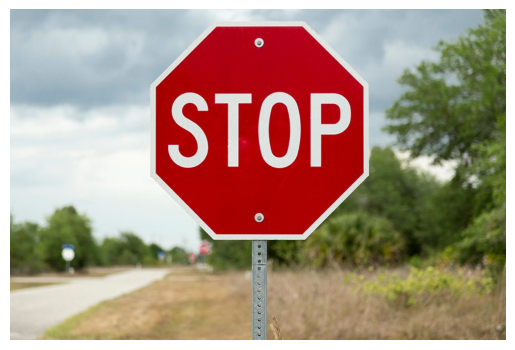

In [3]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
def gaussian_blur_canny(image, kernel_size=5, canny_low=50, canny_high=150):
   
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return edges

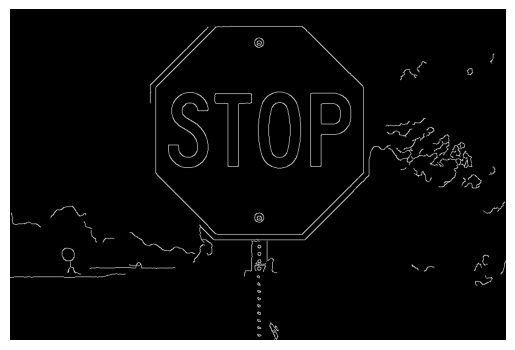

In [7]:
canny=gaussian_blur_canny(img)
plt.imshow(canny,cmap='gray')
plt.axis('off')
plt.show()

In [8]:
def extract_shape_boundaries(image, kernel_size=5,min_area=100):
 
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = np.zeros_like(image)
    
    # Filter and draw only significant shape boundaries
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area: 
            cv2.drawContours(result, [contour], -1, 255, 1)
    
    return result


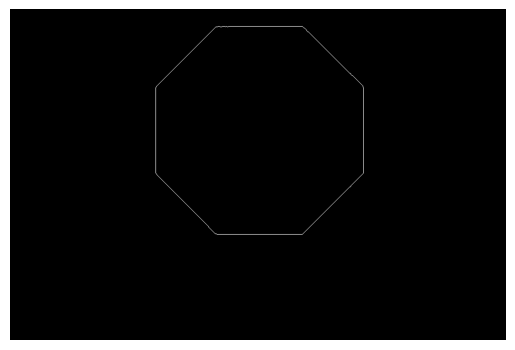

In [9]:
bound=extract_shape_boundaries(canny, min_area=500)
plt.imshow(bound,cmap='gray')
plt.axis('off')
plt.show()

In [10]:
def extract_inner_region(original_image, boundary_image):
 
    mask = boundary_image.copy()
    
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Fill the interior of each contour to create a solid mask
    for contour in contours:
        cv2.fillPoly(mask, [contour], 255)
    
    
    mask_normalized = mask.astype(np.float32) / 255.0
    
    # Apply the mask to preserve original colors
    if len(original_image.shape) == 3:  
        result = original_image.copy().astype(np.float32)
        for i in range(3):
            result[:, :, i] = result[:, :, i] * mask_normalized
        result = result.astype(np.uint8)
    else: 
        result = (original_image.astype(np.float32) * mask_normalized).astype(np.uint8)
    
    return result, mask

In [11]:
inner_region, mask = extract_inner_region(img,bound)

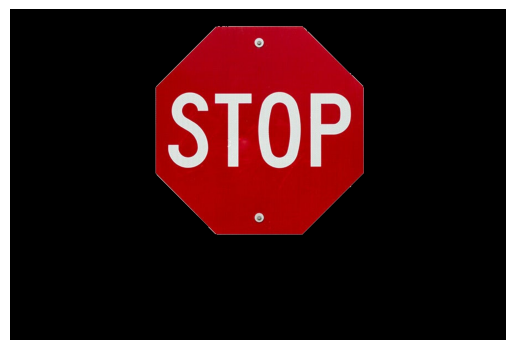

In [12]:
inner_rgb = cv2.cvtColor(inner_region, cv2.COLOR_BGR2RGB)
plt.imshow(inner_rgb,cmap='gray')
plt.axis('off')
plt.show()

In [13]:
def analyze_colors(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    color_ranges = {
        'red': [
            (np.array([0, 100, 100]), np.array([10, 255, 255])),            # Stop, warning, prohibition signs
            (np.array([170, 100, 100]), np.array([180, 255, 255]))          # Stop, warning, prohibition signs
        ],
        'blue': [(np.array([100, 100, 100]), np.array([130, 255, 255]))],   # Mandatory/information signs
        'yellow': [(np.array([20, 100, 100]), np.array([30, 255, 255]))],   # Warning signs
        'green': [(np.array([40, 100, 100]), np.array([80, 255, 255]))],    # Direction/guide signs
        'orange': [(np.array([10, 100, 100]), np.array([20, 255, 255]))],   # Construction/temporary signs
        'brown': [(np.array([8, 100, 50]), np.array([15, 255, 150]))]       # Tourist/recreational signs
    }
    
    color_pixels = {}
    
    # Only count non-black pixels (ignore background)
    non_black_mask = cv2.inRange(hsv, np.array([0, 0, 1]), np.array([180, 255, 255]))
    total_pixels = cv2.countNonZero(non_black_mask)
    
    if total_pixels == 0:
        return "unknown", {}
    
    for color_name, ranges in color_ranges.items():
        mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
        
        for lower, upper in ranges:
            color_mask = cv2.inRange(hsv, lower, upper)
            mask = cv2.bitwise_or(mask, color_mask)
        
        # Only count pixels that are also non-black
        final_mask = cv2.bitwise_and(mask, non_black_mask)
        pixel_count = cv2.countNonZero(final_mask)
        color_pixels[color_name] = pixel_count / total_pixels if total_pixels > 0 else 0
    
    # Find dominant significant color (ignore colors with <2% presence)
    significant_colors = {k: v for k, v in color_pixels.items() if v > 0.02}
    
    if significant_colors:
        dominant_color = max(significant_colors, key=significant_colors.get)
        return dominant_color, significant_colors
    else:
        return "no_significant_color", color_pixels

In [14]:
dominant_color, color_percentages = analyze_colors(inner_region)
    
print(f"Dominant color: {dominant_color}")
print("Significant color percentages:")
for color, percentage in sorted(color_percentages.items(), key=lambda x: x[1], reverse=True):
    if percentage > 0.01:  
        print(f"  {color}: {percentage*100:.1f}%")

Dominant color: red
Significant color percentages:
  red: 83.5%
